In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
sys.path.insert(0, 'utils/')
from factorizer import *
import ssd
import palettable
from scipy.interpolate import griddata
from palettable.cartocolors.qualitative import Prism_8
import matplotlib as mpl
import pickle
from mpl_toolkits.mplot3d import Axes3D
import os

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
fig_path = "figures/BBQ" 
#create directory if it does not exist
try:
    os.mkdir(fig_path)
except:
    print(f"already have directory {fig_path}")

already have directory figures/BBQ


## QTL figures

In [4]:
file_g = "../QTL/BBQ_data_processed/geno_train.npy"
file_e = "../QTL/BBQ_data_processed/pheno_train.npy"

X = np.load(file_g)
Y = np.load(file_e)

In [6]:
data_snp = pd.read_excel("./data/elife-73983-supp1-v2.xlsx")

In [7]:
snp_names = np.array(data_snp['SNP'])
chr_num = np.array(data_snp['Chromosome'])
snp_chr = np.array([[int(s[3:]),chr_num[i]] for i,s in enumerate(snp_names) if s != 'END'])
chr_boundaries = []
for i in range(len(snp_chr)-1):
    if snp_chr[i,1]!= snp_chr[i+1,1]:
        chr_boundaries += [snp_chr[i,0]+0.5]
chr_boundaries = np.array(chr_boundaries)

chr_mids = np.zeros(16)
for i in range(16):
    chr_mids[i] = np.mean(snp_chr[snp_chr[:,1] == i+1,0])

In [8]:
E = Y.shape[1]
S = X.shape[1]
Fraw = np.zeros((E,S))

print(E,S)
N = 25000

for i in range(S):
    filt = X[:N,i] == True
    Fraw[:,i] = 0.5*(np.nanmean(Y[:N][filt],axis=0) - np.nanmean(Y[:N][~filt],axis=0))

18 41594


## 2d figure

['23C', '25C', '27C', '30C', '33C', '35C', '37C', '4NQO', 'cu', 'eth', 'gu', 'li', 'mann', 'mol', 'raff', 'sds', 'suloc', 'ynb']
23C
30C
37C


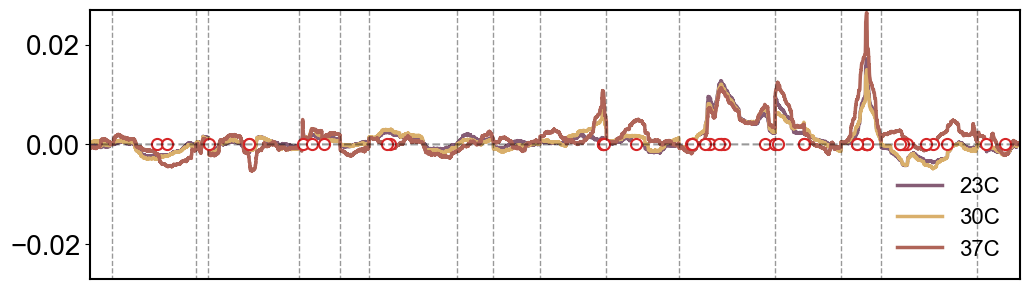

li
mol


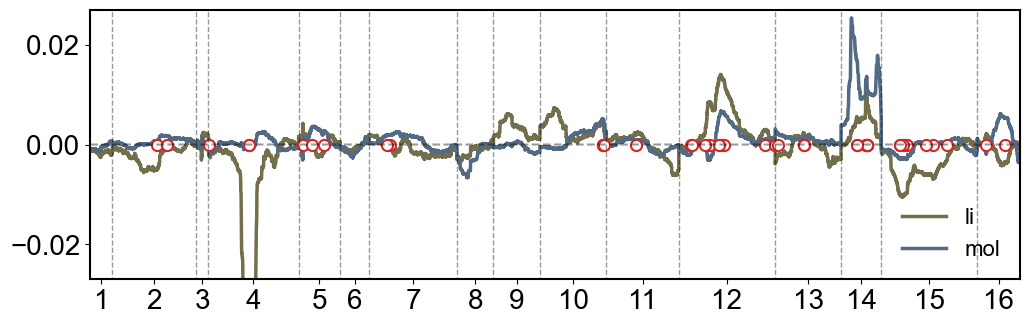

In [9]:
from palettable.cartocolors.qualitative import Antique_5
cmap = Antique_5

directory = "pickled_factorizers"
mode = f"bbq"
fcts = pickle.load(open(f"{directory}/{mode}","rb"))
name = "BBQ"
fct = fcts[(name , None,None)]

Ftrue = fct.FTrue
causal_loci = fct.loci_names
envs = fct.env_names

sort_loci = np.argsort(-np.mean(np.abs(Ftrue),axis=0))

print(envs)
causal_loci_sorted = causal_loci[sort_loci]

env_to_plot = [[0,3,6],[11,13]]
i = 0
for ie in range(len(env_to_plot)):
    plt.close("all")
    fig,axis = plt.subplots(figsize = (12,3.5))
    
    for e in env_to_plot[ie]:
        
        axis.plot(np.arange(S),Fraw[e], c= cmap.mpl_colors[i],label = envs[e],lw = 2.5)
        
        
        print(envs[e])
        i+=1
    axis.plot(causal_loci_sorted[:50],np.zeros(50),'C3o', mfc = 'w', mew = 1.5, ms = 8)
    axis.plot(np.arange(S),np.zeros(S),'k--',alpha = 0.4)
    for ic in range(len(chr_boundaries)):
        axis.plot([chr_boundaries[ic],chr_boundaries[ic]],[-1,1],'k--',lw = 1,alpha = 0.4)
    
    axis.set_ylim(-0.027,0.027)
    axis.set_xlim(-1,S+1)
    axis.legend(fontsize = 16, loc = 4,frameon = False)
    
    axis.tick_params(labelsize = 20)
    axis.set_xticks(chr_mids)
    axis.set_xticklabels(np.arange(1,17))
    if ie != len(env_to_plot) - 1:
        axis.set_xticks([])
    for sp in ['top','bottom','left','right']:
        axis.spines[sp].set_linewidth(1.5)
    fig.savefig(fig_path + "Fraw_%d.pdf"%ie)
    plt.show()

## 3d figure 

51


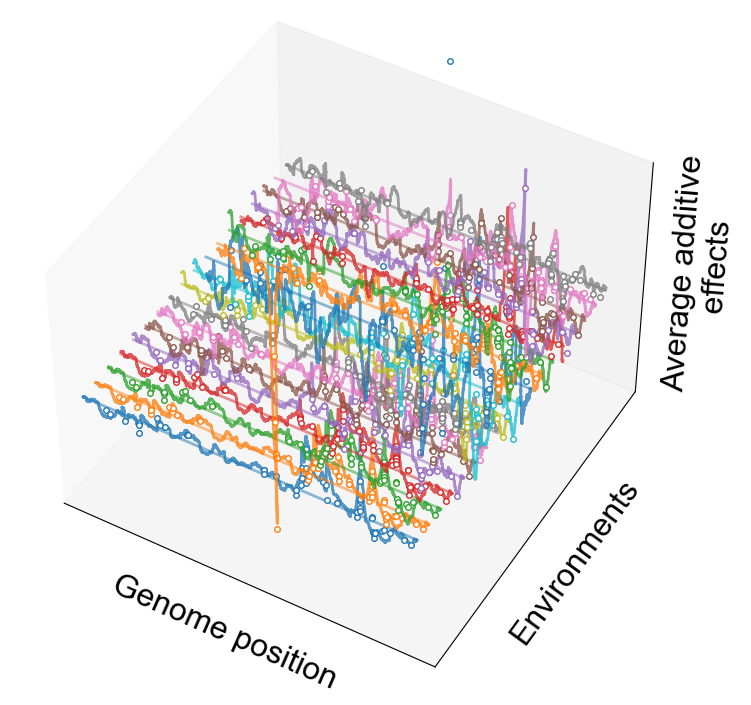

In [11]:
plt.close("all")
fig = plt.figure(figsize = (10,7))

ax = fig.add_subplot(111, projection='3d')

filtL = np.mean(np.abs(Ftrue),axis=0) > 0.00175


print(sum(filtL))

for e in range(E):
    ax.plot(np.arange(S),np.ones(S)*e,Fraw[e,:], 'C%d-'%(e%10), alpha = 0.75,lw = 2)
    ax.plot(np.arange(S),np.ones(S)*e,np.zeros(S),'C%d-'%(e%10), alpha = 0.5, lw = 2)
    
    ax.plot(causal_loci[filtL], np.ones(len(causal_loci[filtL]))*e, Ftrue[e,filtL],'C%do'%(e%10), ms = 4, mfc = 'w', mew = 1)
    

ax.tick_params(labelsize = 14)
ax.set_zlim(-0.025,0.025)
ax.set_ylim(0,18)
ax.grid('off')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_yticklabels(envs,fontsize = 12)
ax.set_zticks([])
ax.set_zlabel("Average additive \n effects", fontsize = 23)
ax.set_xlabel("Genome position", fontsize = 23)
ax.set_ylabel("Environments", fontsize = 23)
ax.view_init(elev = 45, azim = -60)
fig.tight_layout()
#ax.set_zticks([])
#ax.axis('off')
fig.savefig(fig_path + "BBQ_Fraw_3d.pdf")
plt.show()

## Rotation tests

In [13]:
lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),25))
lamb1_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),25))
lamb1_fixed = [1e-4]
lamb2_fixed = [1e-3]
directory = "pickled_factorizers"
mode = f"bbq"
print(mode)
fcts = pickle.load(open(f"{directory}/{mode}","rb"))

bbq


8 18 1089


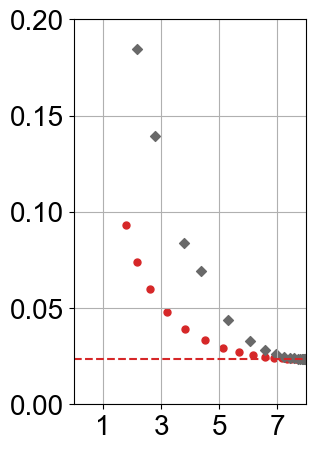

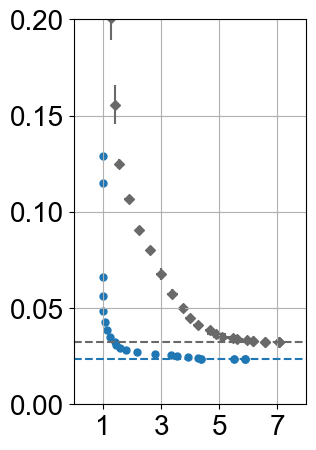

In [14]:
yrange = (0,.2)
xrange = (0,8)
figsize = (3,5)

name = "BBQ"
fct = fcts[(name , None,None)]
K = fct.computed_params(printout = False)[0][1]
print(K, fct.FF.shape[0], fct.FF.shape[1])

fct_rots = [fcts[(name, None, i)] for i in [3,4,5]] 
rotate = "loci"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_fixed, lamb2_range, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,3,5,7], oc='tab:red', rotc='dimgrey', labels= False, legend = False)

fct_rots = [fcts[(name, i, None)] for i in [0,1,2]] 
rotate = "env"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_range, lamb2_fixed, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,3,5,7], oc='tab:blue', rotc='dimgrey', labels= False, legend = False)

## Selected SSD solution

('reg', 8, (0.0015, 0.6013), (0, 0)) 3.0546792849631967 1.6666666666666667 8 0.05674318021295547


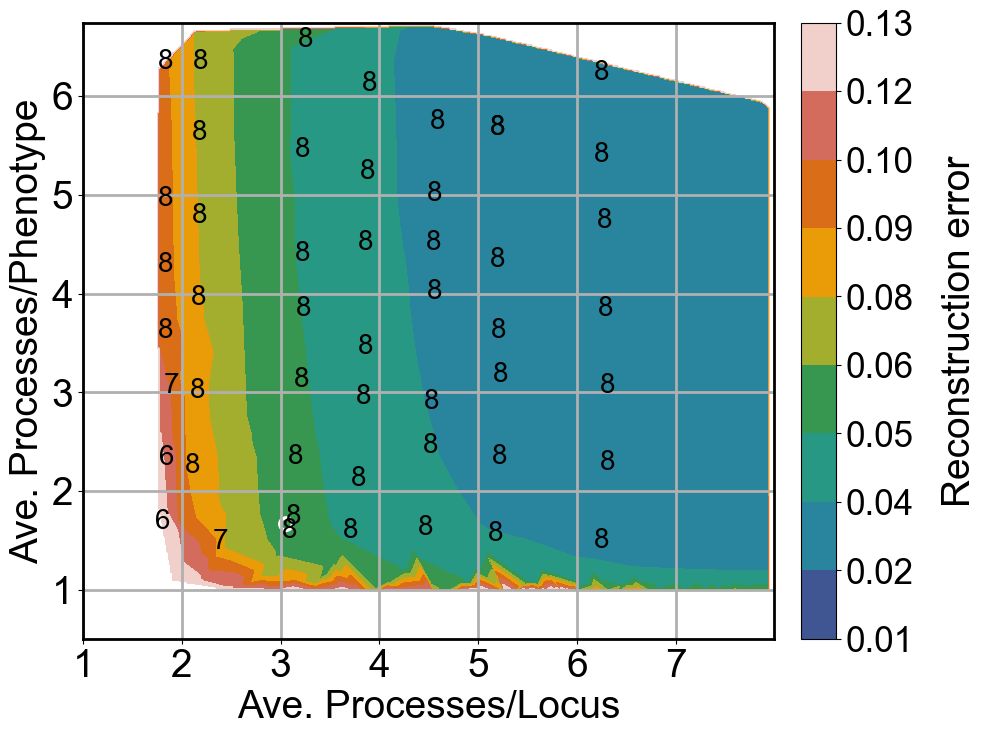

In [15]:
ve = .25
minx = 1.25-ve
maxx = 7.75+ve
miny = 0.75-ve
maxy = 6.5+ve
vmax = 0.13
vmin = 0.01

#K = 12

kpts = []
for i in np.linspace(1.5,6,7):
    for j in np.linspace(1.5,6,7):
        kpts.append((i,j))
        
cps = [(3.2,1.6)]
kpts += cps

plot_solution_space(fct, K, lamb1_range, lamb2_range,  minx, maxx, miny, maxy, vmax, vmin, \
                    fs = 28,scatter=False, scatter_restricted=True, restrict_in_range = True,\
                    k_labeled_points = kpts, circled_points = cps,  save_name = fig_path + "sols_" + mode + ".pdf")

W: plot



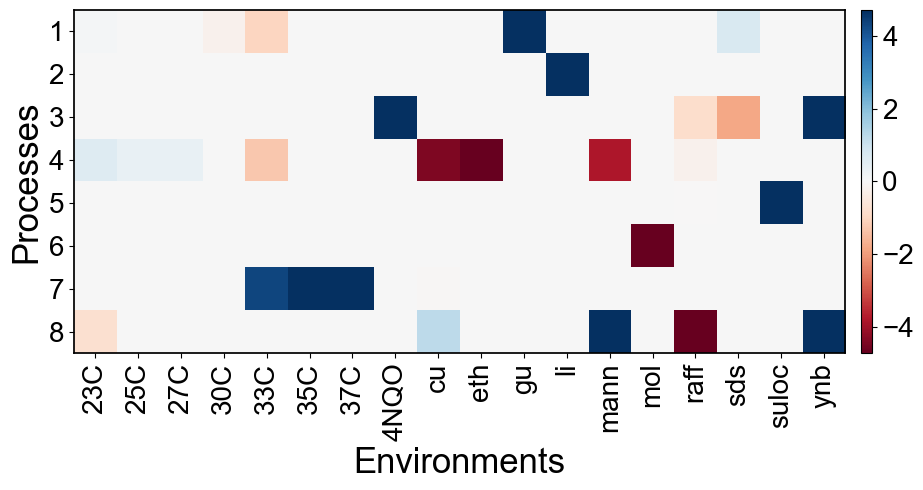

In [16]:
F = fct.FF
p = fct.find_key(3.2,1.6)
#plot_Ws(fct, p, pp = 94, labelsize = 20,save_name = None)
plot_Ws(fct, p, pp = 94, labelsize = 20,save_name = fig_path + "W_" + mode + ".pdf")

## Supplementary figure showing performance on test set and robustness of W matrix features in different solutions 

In [17]:
K = 8
fct.svd(K)
svd_p = ('svd', K, None, (0, 0))
p = fct.find_key(3.2,1.6)

In [18]:
SSD_errors = fct.R2Vs[p]
SVD_errors = fct.R2Vs[svd_p]
F_errors = fct.get_r2s(fct.FTrue, dset="val")

In [19]:
dfe = pd.DataFrame(list(zip(F_errors, SVD_errors, SSD_errors)), columns =['F', 'SVD', 'SSD'], index = fct.env_names)

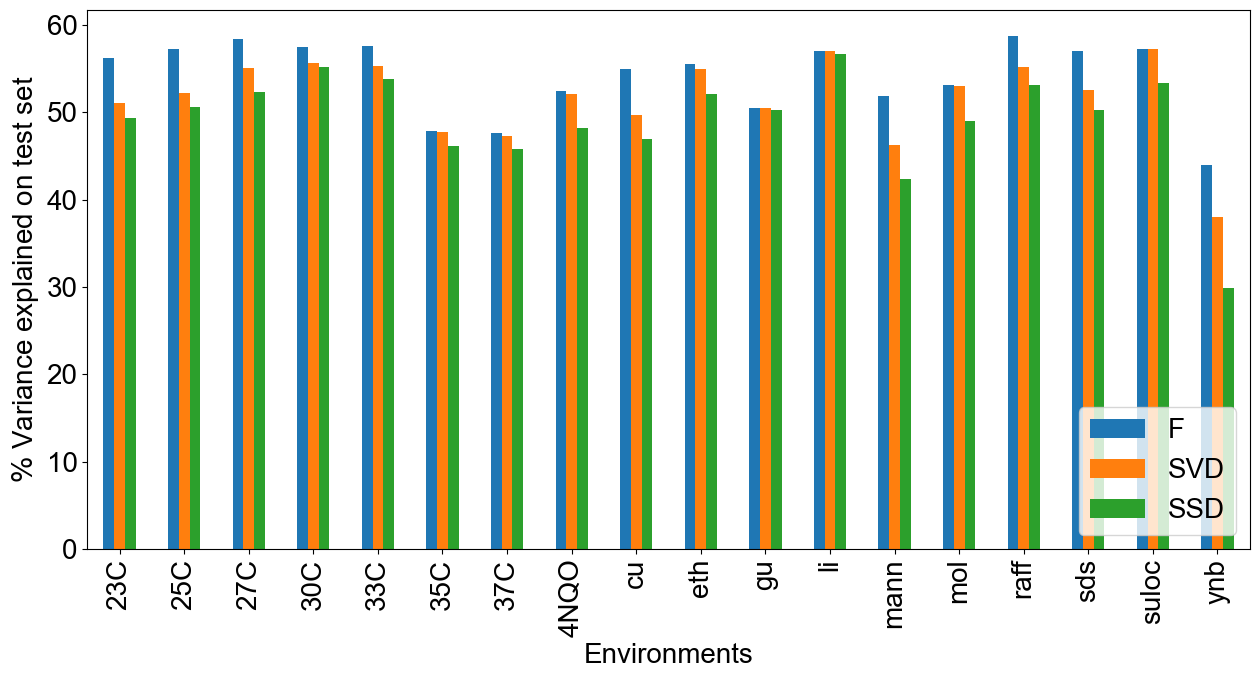

In [20]:
fig = dfe.plot.bar(figsize=(15,7), fontsize = 20)
fig.legend(loc=4, fontsize = 20) 
fig.set_xlabel("Environments", fontsize = 20)
fig.set_ylabel("$\%$ Variance explained on test set", fontsize = 20)
fig.figure.savefig(fig_path + "eval_on_test_set" + ".pdf")

## Examine other solutions 

('reg', 8, (0.0015, 0.3269), (0, 0)) 4.447162426614481 1.6666666666666667 8 0.040449159762651885
('reg', 8, (0.0026, 1.106), (0, 0)) 1.9975186104218363 1.5384615384615385 6 0.11427196168325422
('reg', 8, (0.0008, 0.6013), (0, 0)) 3.1304801670146136 3.0555555555555554 8 0.05229823269696191


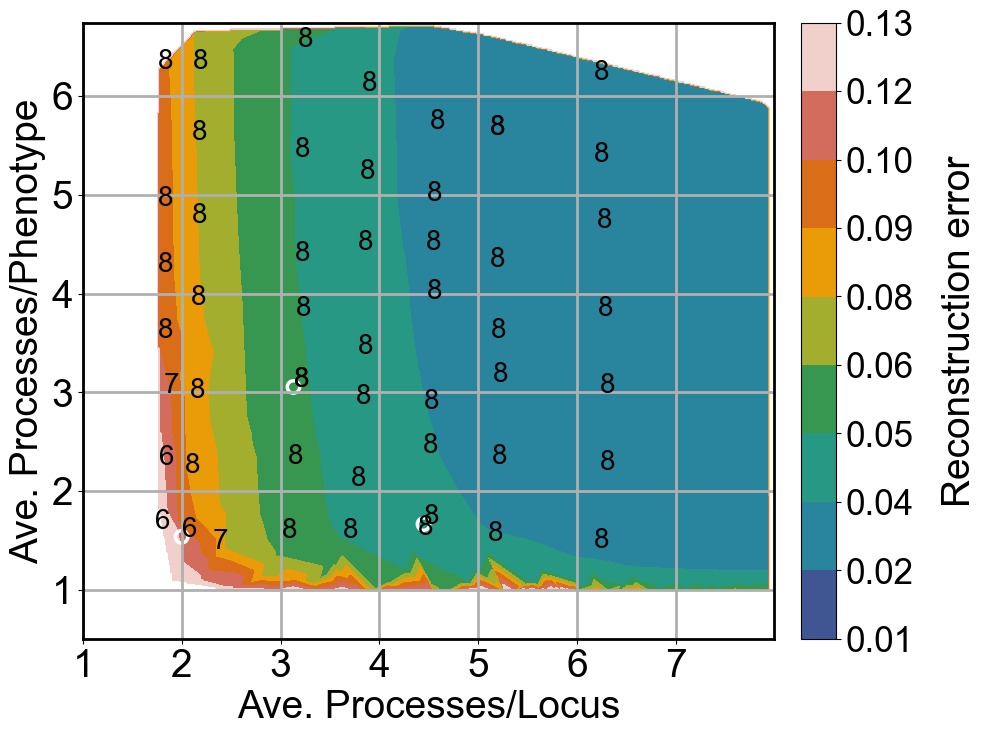

In [21]:
ve = .25
minx = 1.25-ve
maxx = 7.75+ve
miny = 0.75-ve
maxy = 6.5+ve
vmax = 0.13
vmin = 0.01

#K = 12

kpts = []
for i in np.linspace(1.5,6,7):
    for j in np.linspace(1.5,6,7):
        kpts.append((i,j))
        
cps = [(4.5,1.6),(2,1.6), (3.2,3.0)]
kpts += cps

plot_solution_space(fct, K, lamb1_range, lamb2_range,  minx, maxx, miny, maxy, vmax, vmin, \
                    fs = 28,scatter=False, scatter_restricted=True, restrict_in_range = True,\
                    k_labeled_points = kpts, circled_points = cps,  save_name = fig_path + "other_sols.pdf")

W: plot



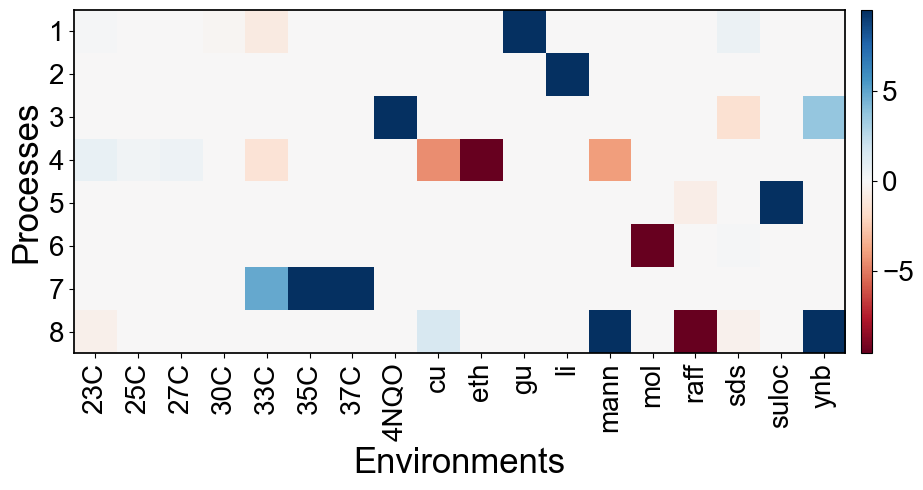

W: plot



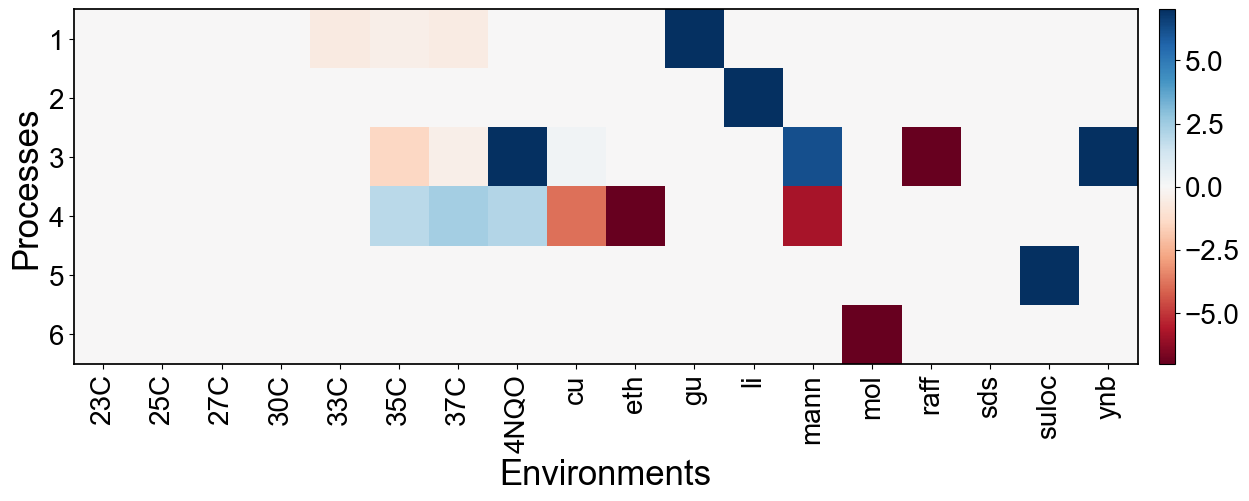

W: plot



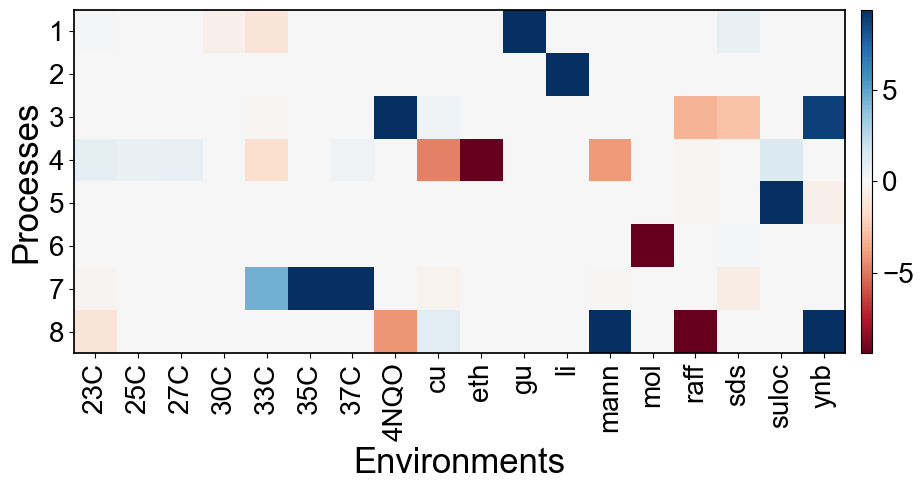

In [22]:
F = fct.FF
p = fct.find_key(4.5,1.6)
plot_Ws(fct, p, pp = 95, labelsize = 20, save_name = fig_path + "W_l4_5_p1_6.pdf")

p = fct.find_key(2,1.6)
plot_Ws(fct, p, pp = 95.4, labelsize = 20,save_name = fig_path + "W_l2_0_p1_6.pdf")

p = fct.find_key(3.2,2.0)
plot_Ws(fct, p, pp = 94.6, labelsize = 20,save_name = fig_path + "W_l3_5_p2_0.pdf")

## Make excel file describing modules

In [23]:
M = fct.M_preds[p]
W = fct.W_preds[p]

In [25]:
results_dir = "../QTL/BBQ_results"
cc= "0.94"
lt1 ="0.0"
lt2 = "0.003"
width = "100"
std = "2"
reg = "l1"
new_dir = f"{results_dir}/CI_after_localization_round_2_cc_{cc}_lt1_{lt1}_lt2_{lt2}_width_{width}_std_{std}_norm_{reg}_orf_and_anno"


In [26]:
loci_to_possible_orfs_d = pickle.load(open(f"{new_dir}/loci_to_possible_orfs_d", "rb"))

In [27]:
df=pd.read_csv(f'{new_dir}/orf_info.csv')
df=df.set_index('0')

In [28]:
loci_to_label_d = {}
for _ in loci_to_possible_orfs_d:
    to_add = []
    if len(loci_to_possible_orfs_d[_]) == 0:
        loci_to_label_d[_]= f"Unannotated loci near {_}"
    else:
        for orf in loci_to_possible_orfs_d[_]:
            gene_name = df.loc[orf, "Standard Gene Name"]
            if gene_name is np.NaN:
                to_add.append(orf)
            else:
                to_add.append(gene_name)
        loci_to_label_d[_]=" or ".join(to_add)

In [29]:
for _ in fct.loci_names:
    if _ not in loci_to_label_d.keys():
        loci_to_label_d[_]=f"never localized {_}"

In [30]:
loci_to_func_d ={}
for key in loci_to_possible_orfs_d:
    if len(loci_to_possible_orfs_d[key])== 1:
        loci_to_func_d[key]=df.loc[loci_to_possible_orfs_d[key][0], "GO_Function"]

In [31]:
loci_to_proc_d ={}
for key in loci_to_possible_orfs_d:
    if len(loci_to_possible_orfs_d[key])== 1:
        loci_to_proc_d[key]=df.loc[loci_to_possible_orfs_d[key][0], "GO_Process"]

In [32]:
thresh = .1

In [33]:
Z = np.argsort(np.abs(M), axis = -1)[:,-25:]
to_write = []
for i in range(M.shape[0]):
    envs = " ".join([fct.env_names[_] for _ in list((np.where(np.abs(W[:,i])>0))[0])])
    print(f"\nModule {i} {envs}")
    to_write.append(f"Module {i} {envs}\n")
    pos = list(Z[i,...])[::-1]
    for j in pos:
        if np.abs(M[i,j])>thresh:
            po = loci_to_possible_orfs_d[fct.loci_names[j]]
            if len(po)>1 or len(po)==0:
                to_add = " or ".join(po)
                to_add = to_add + "\t\t\t\t\t\t\t"
            else:
                to_add = po[0] +"\t"+"\t".join([str(z) for z in df.loc[po[0]]])
            line = f"{M[i,j]:.2f}\t{j}\t{fct.loci_names[j]}\t{to_add}" 
            print(line)
            to_write.append(line + "\n")


Module 0 23C 30C 33C gu sds
0.54	774	30645	YLL058W	HSU1	Hydrogen Sulfide Utilising-1	Protein of unknown function, affects S-methylmethionine metabolism	Protein of unknown function, affects S-methylmethionine metabolism; has similarity to Str2p, which is a cystathionine gamma-synthase important in sulfur metabolism; HSU1 is not an essential gene	Putative cystathionine gamma-synthase involved in sulfur metabolism	nan	nan
-0.27	732	28215	YLR256W	HAP1	Heme Activator Protein	Zinc finger transcription factor	Zinc finger transcription factor; involved in the complex regulation of gene expression in response to levels of heme and oxygen; localizes to the mitochondrion as well as to the nucleus; the S288C sequence differs from other strain backgrounds due to a Ty1 insertion in the carboxy terminus	A transcription factor that binds to sequence-specific DNA proximal to RNA polymerase II core promoter that is involved in regulation of transcription in response to hypoxia; localized to both the nu

KeyError: 34547

In [34]:
F = open(f"{new_dir}/mod_anno.tsv", "w")
F.writelines(to_write)
F.close()

In [35]:
Z = np.argsort(np.abs(M), axis = -1)[:,-10:]
for i in range(M.shape[0]):
    print(f"\nModule {i}")
    pos = list(Z[i,...])[::-1]
    for j in pos:
        if fct.loci_names[j] in  loci_to_func_d:
            print(f"{M[i,j]:.2f}\t{fct.loci_names[j]}\t{loci_to_label_d[fct.loci_names[j]]}\t{loci_to_func_d[fct.loci_names[j]]}")
        else:
            print(f"{M[i,j]:.2f}\t{fct.loci_names[j]}\t{loci_to_label_d[fct.loci_names[j]]}")

        


Module 0
0.54	30645	HSU1	nan
-0.27	28215	HAP1	DNA binding (26) DNA-binding transcription factor activity (10)
-0.19	8533	JIP4	nan
-0.19	30747	BUL2	transferase activity (14)
-0.18	28220	YLRWdelta15 or YLRWsigma3
0.16	30646	BUL2	transferase activity (14)
0.15	38342	INP53 or TFC7
0.13	34743	Unannotated loci near 34743
0.12	39497	MNE1 or MEK1 or TFB6
0.12	22971	VPS70 or RSF2

Module 1
-0.76	7117	ENA1	transmembrane transporter activity (26)
-0.44	7115	ENA5	transmembrane transporter activity (26)
-0.25	7140	AIM7 or LCB2 or YDR064W_intron or RRG1
-0.17	30645	HSU1	nan
-0.09	36231	HAL9	DNA binding (26)
-0.08	6949	ATP16 or MED2
-0.08	26206	PTR2	transmembrane transporter activity (26)
-0.07	36239	HAL9	DNA binding (26)
0.07	28215	HAP1	DNA binding (26) DNA-binding transcription factor activity (10)
-0.07	7252	PPH3 or RAD55

Module 2
-0.50	34730	MKT1	nuclease activity (7)
-0.37	28215	HAP1	DNA binding (26) DNA-binding transcription factor activity (10)
-0.29	26939	RAD5	DNA binding (26) helicase acti

## Sankey

In [36]:
M = fct.M_preds[p]
W = fct.W_preds[p]

In [37]:
thresh = .2
MM = np.abs(M)
WW = np.abs(W)
dont_flip = np.where(np.sum(W, axis = 0)>0)[0]
print(dont_flip)
keep = MM.max(axis = 0)>thresh
M = M[:, keep]
MM = MM[:, keep]
print(MM.shape)

[0 1 2 4 6 7]
(8, 27)


In [38]:
names = []
for _ in range(keep.shape[0]):
    if keep[_]:
        names.append(loci_to_label_d[fct.loci_names[_]])
    

In [39]:
res = []
for i in range(M.shape[0]):
    total = 0
    displayed = 0
    for j in range(M.shape[1]):
        if np.abs(M[i,j])>thresh: 
            displayed += np.abs(M[i,j])
        total += np.abs(M[i,j])
    res.append(total - displayed)

In [40]:
print(res)

[0.8830873456827577, 0.6099273972465025, 0.5109777659712778, 1.336153427052088, 0.6985498403534649, 0.4587112901270358, 0.4903443106143308, 0.5888065274965204]


In [43]:
import plotly.express as px

In [44]:
label = [f"Mod. {i}" for i in range(MM.shape[0])] + names + fct.env_names  +["all other effects"]
source = []
target = []
value = []
color = []
if False:
    for i in range(MM.shape[0]):
        target.append(i)
        source.append(len(label)-1)
        value.append(res[i])
        color.append('white')

    
for i in range(MM.shape[0]):
    for j in range(MM.shape[1]):
        if MM[i,j]<thresh: continue
        target.append(i)
        source.append(j+MM.shape[0])
        value.append(MM[i,j])
        #if M[i,j]<0:
        #print(label[j+MM.shape[0]], label[i], i in dont_flip, M[i,j]<0,(2*(i in dont_flip)-1) * M[i,j]<0 )
        #print(MM[i,j],M[i,j],(2*(i in dont_flip)-1) * M[i,j] )
        if (2*(i in dont_flip)-1) * M[i,j]<0:
            color.append(px.colors.qualitative.Set1[i])
        else: 
            color.append(px.colors.qualitative.Pastel1[i])

    
    
for i in range(WW.shape[1]):
    for j in range(WW.shape[0]):
        source.append(i)
        target.append(j+MM.shape[0]+MM.shape[1])
        value.append(WW[j,i]/50)
        #if W[j,i]<0:
        if (2*(i in dont_flip)-1) * W[j,i]<0:
            color.append('rgb(70,70,70)')
        else: 
            color.append(px.colors.qualitative.Pastel2[-1])

In [49]:
import plotly.graph_objects as go
import plotly.io as pio
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = "black"

    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color
  ))])

fig.update_layout(title_text="Module map", font_size=16,  width=700, height=1200)
fig.show()
#pio.write_image(fig, fig_path + "sankey_small.svg")